In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.meteor_score import meteor_score
import skimage.transform
import copy
import cv2
from google.colab.patches import cv2_imshow

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [4]:
set_seed(42)

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [9]:
import gdown
import zipfile
import os

google_drive_link = "https://drive.google.com/uc?id=1mehPj1VVwgKyqtqmq4rwkTJTA_tSMD9_"
download_path = "data.zip"
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

gdown.download(google_drive_link, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(download_path)

list_of_files = os.listdir(input_dir)
print("List of files in input directory:")
print(list_of_files)


# Preprocessing Images

In [10]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [11]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [12]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

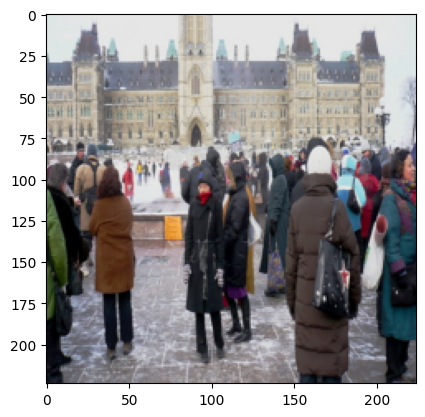

In [13]:
display_image(Images,1)

# Preprocessing Captions

In [14]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [15]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [16]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [17]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [18]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [19]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [20]:
train_split = int(0.8*len(list_of_files))
val_split = (len(list_of_files) - train_split)

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:,:,:,:]

In [21]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [22]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> two men are wrestling in competition <end>', '<start> two men are wrestling while other people are watching <end>', '<start> two men wrestle on the floor in front of an group of young men <end>', '<start> two men wrestling at match <end>', '<start> two young men competing in wrestling tournament <end>']


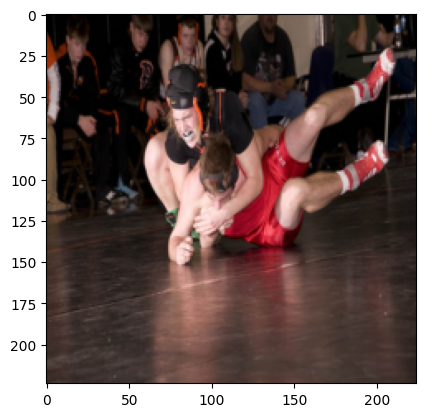

In [23]:
print(train_captions[0])
display_image(train_images,0)

In [24]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7804
6472
6472


# Captions Dataset

In [25]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [26]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [27]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [28]:
class CNN_model_1(nn.Module):
    def __init__(self):
        super(CNN_model_1,self).__init__()
        resnet=models.resnet50(pretrained=True)
        for p in resnet.parameters():
            p.requires_grad_(False)
        modules=list(resnet.children())[:-2]
        self.resnet=nn.Sequential(*modules)
    def forward(self,images):
        features=self.resnet(images)
        features=features.permute(0,2,3,1)
        features=features.view(features.size(0),-1,features.size(-1))
#         print(features.shape)
        return features #(batch_size,49,2048)

# LSTM and Transformer part of the decoder

In [29]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention,self).__init__()
        self.U=nn.Linear(512,512)
        self.W=nn.Linear(2048,512)
        self.v=nn.Linear(512,1)
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(1)

    def forward(self,features,hidden_states):
        U_hidden=self.U(hidden_states)#(batch_size,512)
        W_features=self.W(features)#(batch_size,49,512)
        attention=self.tanh(U_hidden.unsqueeze(1)+W_features)
        e=self.v(attention).squeeze(2) #(batch_size,1)
        alpha=self.softmax(e)
        context=(features*alpha.unsqueeze(2)).sum(1)
        return alpha,context

In [30]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention()
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = len(captions[0])-1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds,alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        alphas = []
        word = torch.tensor(vocab[1]['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            if vocab[0][predicted_word_idx.item()] == "<end>":
                break
            captions.append(predicted_word_idx.item())
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        return " ".join([vocab[0][idx] for idx in captions]),alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

# Integrating the 2 parts of the model

In [31]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs,alpha = self.decoder(features,captions)
    return features,outputs,alpha

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.generate_captions(features)
    return prediction


In [32]:
def validate(model):
  actual_captions = []
  generated_captions = []
  total_meteor_score = 0
  for data in tqdm(val_loader):
    image, caption_set = data
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab)[0].split())
    total_meteor_score += round(meteor_score(actual_captions[-1],generated_captions[-1]),4)
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  total_meteor_score /= len(generated_captions)
#   bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'Meteor_score:{total_meteor_score}')
  return total_meteor_score

In [33]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_score = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for (img,cap,caplen) in tqdm(train_loader):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs,alpha = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap[:,1:].reshape(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
                perp = np.exp(loss.item())
            average_loss = average_loss/count
            average_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            score = validate(model)
            if score > best_score:
              print("checkpointing best model")
              best_checkpoint_model = copy.copy(model)
              best_score = score
            # validate(model)
      return model,best_checkpoint_model

# Calling Functions

In [34]:
learning_rate = 0.0003
num_epochs = 1
embed_size=300
hidden_size=512
attention_size = 256
vocab_size=len(vocab[0])
n_layers=2

In [35]:
# decoder = (embed_size,hidden_size,vocab_size,n_layers)
decoder = DecoderRNN(embed_size,vocab_size,attention_size,2048,hidden_size)
encoder = CNN_model_1()
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


In [36]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

Val_dataset consist of 1619 images each with 5 captions, making 8095 captions. and the len of the caption_dataset is defined to be number of captions so, it shows up as 8095 but runs for 1619 images.

Whereas in train, we have restricted the indices so that we run on each image once, so it runs for 6472 images

In [43]:
final_model,best_checkpoint_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 9)

100%|██████████| 6472/6472 [03:42<00:00, 29.04it/s]


Epoch [1/9], Loss: 4.4849, Perplexity: 88.6690


100%|██████████| 8095/8095 [02:32<00:00, 53.17it/s]


BLEU-1: 0.26558569249695885
BLEU-2: 0.1326406285146421
BLEU-3: 0.06591345331474016
BLEU-4: 0.03317813801959046
Meteor_score:0.14004384187770413
checkpointing best model


100%|██████████| 8095/8095 [02:31<00:00, 53.38it/s]


BLEU-1: 0.26824206820923446
BLEU-2: 0.1335580358011491
BLEU-3: 0.06690158168460693
BLEU-4: 0.03328263886387498
Meteor_score:0.14134417541692523


100%|██████████| 6472/6472 [03:43<00:00, 29.01it/s]


Epoch [2/9], Loss: 4.3332, Perplexity: 76.1879


100%|██████████| 8095/8095 [02:32<00:00, 53.09it/s]


BLEU-1: 0.2677196488083866
BLEU-2: 0.13433460431458863
BLEU-3: 0.0657835521261277
BLEU-4: 0.031981044173655056
Meteor_score:0.14348331068561007
checkpointing best model


100%|██████████| 8095/8095 [02:30<00:00, 53.79it/s]


BLEU-1: 0.2705077271558864
BLEU-2: 0.1360244168923221
BLEU-3: 0.06766584683315136
BLEU-4: 0.03249519413609422
Meteor_score:0.14458172946263348


100%|██████████| 6472/6472 [03:57<00:00, 27.29it/s]


Epoch [3/9], Loss: 4.2438, Perplexity: 69.6699


100%|██████████| 8095/8095 [02:31<00:00, 53.45it/s]


BLEU-1: 0.26456115424903864
BLEU-2: 0.1277592215403452
BLEU-3: 0.06202101957231033
BLEU-4: 0.02972819130975801
Meteor_score:0.13303655342804224


100%|██████████| 8095/8095 [02:30<00:00, 53.79it/s]


BLEU-1: 0.2656669509121982
BLEU-2: 0.12602586303399455
BLEU-3: 0.0598501894540217
BLEU-4: 0.028461959933085926
Meteor_score:0.13255357628165595


100%|██████████| 6472/6472 [03:43<00:00, 28.94it/s]


Epoch [4/9], Loss: 4.1931, Perplexity: 66.2283


100%|██████████| 8095/8095 [02:36<00:00, 51.78it/s]


BLEU-1: 0.27698676587142845
BLEU-2: 0.13573720330779038
BLEU-3: 0.06597297272128164
BLEU-4: 0.03176849684925077
Meteor_score:0.14669928350833927
checkpointing best model


100%|██████████| 8095/8095 [02:35<00:00, 51.98it/s]


BLEU-1: 0.2776323797481794
BLEU-2: 0.13643535654985772
BLEU-3: 0.06675941061342905
BLEU-4: 0.03311205830144152
Meteor_score:0.146597109326746


100%|██████████| 6472/6472 [03:41<00:00, 29.27it/s]


Epoch [5/9], Loss: 4.1245, Perplexity: 61.8354


100%|██████████| 8095/8095 [02:35<00:00, 51.91it/s]


BLEU-1: 0.2546859958437043
BLEU-2: 0.12417157095797271
BLEU-3: 0.06071264323809854
BLEU-4: 0.030364509892878092
Meteor_score:0.1519225694873392
checkpointing best model


100%|██████████| 8095/8095 [02:37<00:00, 51.27it/s]


BLEU-1: 0.2588325885817454
BLEU-2: 0.1280464224474774
BLEU-3: 0.06361413427509
BLEU-4: 0.030409449041235326
Meteor_score:0.1535692526250778


100%|██████████| 6472/6472 [03:41<00:00, 29.19it/s]


Epoch [6/9], Loss: 4.1009, Perplexity: 60.3975


100%|██████████| 8095/8095 [02:39<00:00, 50.69it/s]


BLEU-1: 0.2925839800856676
BLEU-2: 0.13696552417074095
BLEU-3: 0.06372041067985462
BLEU-4: 0.02990223543802277
Meteor_score:0.1422817665225447


100%|██████████| 8095/8095 [02:38<00:00, 51.05it/s]


BLEU-1: 0.29663363963737976
BLEU-2: 0.13997454586049682
BLEU-3: 0.0676117978951944
BLEU-4: 0.0331068283862874
Meteor_score:0.14496872143298295


100%|██████████| 6472/6472 [03:41<00:00, 29.27it/s]


Epoch [7/9], Loss: 4.0722, Perplexity: 58.6864


100%|██████████| 8095/8095 [02:36<00:00, 51.64it/s]


BLEU-1: 0.27622557716840135
BLEU-2: 0.1289316736518041
BLEU-3: 0.06282540113917483
BLEU-4: 0.0317024638421344
Meteor_score:0.1383685114268067


100%|██████████| 8095/8095 [02:36<00:00, 51.76it/s]


BLEU-1: 0.273307141533539
BLEU-2: 0.12744715222477862
BLEU-3: 0.06225036252400254
BLEU-4: 0.03192177309648805
Meteor_score:0.13702147004323606


100%|██████████| 6472/6472 [03:39<00:00, 29.48it/s]


Epoch [8/9], Loss: 4.0407, Perplexity: 56.8643


100%|██████████| 8095/8095 [02:35<00:00, 52.06it/s]


BLEU-1: 0.2709829949094361
BLEU-2: 0.129338211241542
BLEU-3: 0.0611556154183769
BLEU-4: 0.029890907076757026
Meteor_score:0.1349077208153175


100%|██████████| 8095/8095 [02:33<00:00, 52.64it/s]


BLEU-1: 0.2702900067780373
BLEU-2: 0.12758447847078053
BLEU-3: 0.060731211342394585
BLEU-4: 0.028804143882286515
Meteor_score:0.13350827671402016


100%|██████████| 6472/6472 [03:40<00:00, 29.34it/s]


Epoch [9/9], Loss: 4.0579, Perplexity: 57.8539


100%|██████████| 8095/8095 [02:37<00:00, 51.44it/s]


BLEU-1: 0.2769033412741402
BLEU-2: 0.12712548759135447
BLEU-3: 0.060856052068593285
BLEU-4: 0.03053137208782379
Meteor_score:0.13790075355157502


100%|██████████| 8095/8095 [02:35<00:00, 51.89it/s]


BLEU-1: 0.2795757578382437
BLEU-2: 0.12831596134861772
BLEU-3: 0.061282736807646294
BLEU-4: 0.030549507190922302
Meteor_score:0.13925420630018565


In [44]:
final_model1,best_checkpoint_model1 = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 1)

100%|██████████| 6472/6472 [03:39<00:00, 29.49it/s]


Epoch [1/1], Loss: 4.0810, Perplexity: 59.2048


100%|██████████| 8095/8095 [02:36<00:00, 51.86it/s]


BLEU-1: 0.2758344349333457
BLEU-2: 0.13202516379597545
BLEU-3: 0.0661374649941369
BLEU-4: 0.03517638674899505
Meteor_score:0.14124623841877731
checkpointing best model


100%|██████████| 8095/8095 [02:34<00:00, 52.51it/s]


BLEU-1: 0.27685056119734724
BLEU-2: 0.13062937891564758
BLEU-3: 0.06370203563558834
BLEU-4: 0.03264730333908829
Meteor_score:0.14113818406423703
